<a href="https://colab.research.google.com/github/bcataldo3/plantilla_curso_python/blob/main/docs/Clase_07 - Modelos Jerárquicos - Caso Estudio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conglomerados Jerárquicos - Caso de Estudio

## Descripción del Caso
Ahora consideremos un problema más detallado en un conjunto de datos más grande que contiene 527 muestras con 38 variables químicas y físicas que describen el estado de las plantas de tratamiento de agua. El dominio está poco estructurado y se necesita un análisis cuidadoso. Al mismo tiempo, nuestro objetivo es encontrar el agrupamiento óptimo con un enfoque agnóstico; es decir, **no consideraremos el proceso de etiquetado semántico (que requiere un experto en el dominio), sino únicamente la estructura geométrica del conjunto de datos y las relaciones descubiertas por el algoritmo aglomerativo**.

La primera columna es un índice relacionado con la planta específica, mientras que todos los demás valores son numéricos y pueden convertirse a float64. Los valores faltantes están indicados con el carácter '?', y como no tenemos otra información, se establecen con la media de cada atributo. Además, dado que las variables individuales tienen magnitudes muy diferentes (invito al lector a verificar esta afirmación utilizando la función ``describe`` en el ``DataFrame``), es preferible normalizarlas en el rango (-1, 1), preservando la varianza origina. En este punto, como es habitual, podemos emplear el algoritmo t-SNE para proyectar el conjunto de datos en un espacio bidimensional. Los resultados y el código vienen a continuación.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘Rcpp’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



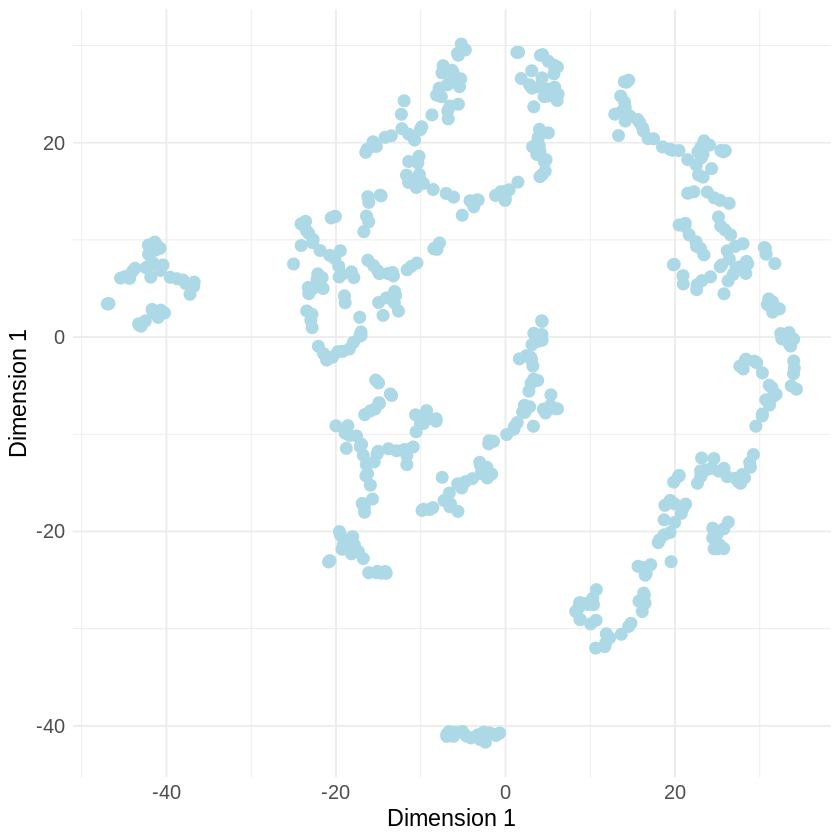

In [2]:
install.packages("tidyverse")
install.packages("Rtsne")
install.packages("httr")
library(tidyverse)
library(Rtsne)
library(httr)

# Cargar la data
url <- "https://drive.google.com/uc?id=1I2pCul5Jcg6wdJrHcUooZ9-PYqSl1C7o"
df <- read.csv(url, header = FALSE, sep = ",", dec = ".", na.strings = "?")
df$V1 <- NULL
df <- data.frame(lapply(df, function(x) as.numeric(x)))
# Rellenar NA con la media de cada columna
df <- sapply(df, function(x) ifelse(is.na(x), mean(x, na.rm = TRUE), x))
# Estandarizar la data (restar la media)
sdf <- scale(df, center = TRUE, scale = FALSE)

# Aplicar reducción de dimensionalidad t-SNE
set.seed(1000)
tsne_results <- Rtsne(as.matrix(sdf), dims = 2, perplexity = 10)

# Crear un dataframe con los resultados de t-SNE
df_tsne <- data.frame(x = tsne_results$Y[,1], y = tsne_results$Y[,2])

# Unir la data original con los resultados de t-SNE
dff <- cbind(df, df_tsne)

# Graficar los resultados
ggplot(dff, aes(x = x, y = y)) +
  geom_point(color = "lightblue", size = 3) +  # Puntos azules y más grandes
  xlab("Dimension 1") +  # Personalizar el título del eje X
  ylab("Dimension 1") +  # Personalizar el título del eje Y
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20),  # Centrar y ajustar el tamaño del título
    axis.text = element_text(size = 12),  # Ajustar el tamaño del texto de los ejes
    axis.title = element_text(size = 14),  # Ajustar el tamaño del título de los ejes
    legend.title = element_text(size = 12)  # Ajustar el tamaño del título de la leyenda
  )

El gráfico muestra una potencial geometría no convexa con muchas pequeñas islas (regiones densas) separadas por espacios vacíos. Sin embargo, sin información de dominio, no es fácil decidir qué conjuntos pueden considerarse partes del mismo grupo. **La única pseudo-restricción que podemos decidir imponer (considerando que todas las plantas operan de manera similar) es tener un número moderado o pequeño de grupos finales**. Por lo tanto, asumiendo la distancia euclidiana y utilizando la clase ``AgglomerativeClustering`` de ``scikit-learn``, podemos calcular tanto la correlación cofenética como la puntuación de silueta para todos los enlaces y para 4, 6, 8 y 10 número de grupos:


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



[1] 0.6084221

The "ward" method has been renamed to "ward.D"; note new "ward.D2"

The "ward" method has been renamed to "ward.D"; note new "ward.D2"

The "ward" method has been renamed to "ward.D"; note new "ward.D2"

The "ward" method has been renamed to "ward.D"; note new "ward.D2"

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


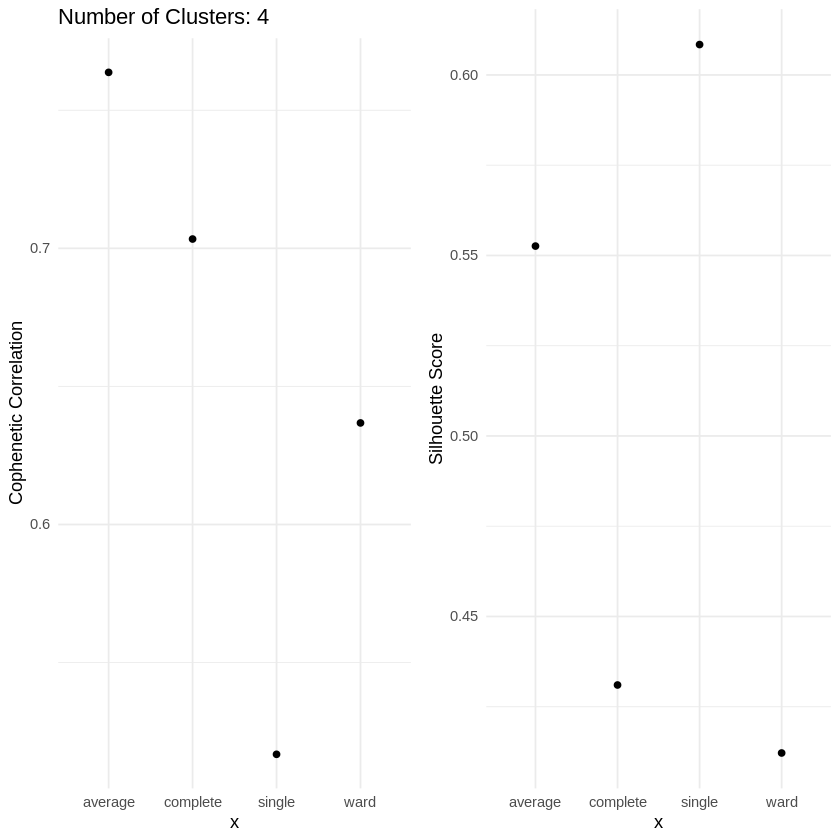

In [5]:
install.packages("gridExtra")
install.packages("cluster")
library(ggplot2)
library(gridExtra)
library(cluster)

# Variables auxiliares
nb_clusters <- c(4, 6, 8, 10)
linkages <- c("single", "complete", "ward", "average")
cpcs <- matrix(0, nrow = length(linkages), ncol = length(nb_clusters))
silhouette_scores <- matrix(0, nrow = length(linkages), ncol = length(nb_clusters))

dm <- dist(sdf, method = 'euclidean')
Z <- hclust(dm, method = "single")
matriz <-cophenetic(Z)
#cor(dm, matriz)
ag <- cutree(Z, k = 4)

silhouette_score_matriz <- silhouette(ag, dm)
mean(silhouette_score_matriz[, "sil_width"])


# Calculo del coeficiente de correlación cophenético y del puntaje de silhouette
for (i in 1:length(linkages)) {
  for (j in 1:length(nb_clusters)) {
    dm <- dist(sdf, method = 'euclidean')
    Z <- hclust(dm, method = linkages[i])
    matriz <- cophenetic(Z)
    cpcs[i, j] <- cor(dm, matriz)
    ag <- cutree(Z, k = nb_clusters[j])
    silhouette_score_matriz <- silhouette(ag, dm)
    silhouette_scores[i, j] <- mean(silhouette_score_matriz[, "sil_width"])
  }
}

i=1
p1 <- ggplot(data.frame(x = linkages, y = cpcs[, i]), aes(x, y)) +
  geom_line() +
  geom_point() +
  labs(title = paste("Number of Clusters:", nb_clusters[i]), y = "Cophenetic Correlation") +
  theme_minimal()
p2 <- ggplot(data.frame(x = linkages, y = silhouette_scores[, i]), aes(x, y)) +
  geom_line() +
  geom_point() +
  labs(y = "Silhouette Score") +
  theme_minimal()
plot_list[[i]] <- grid.arrange(p1, p2, nrow = 1)


`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


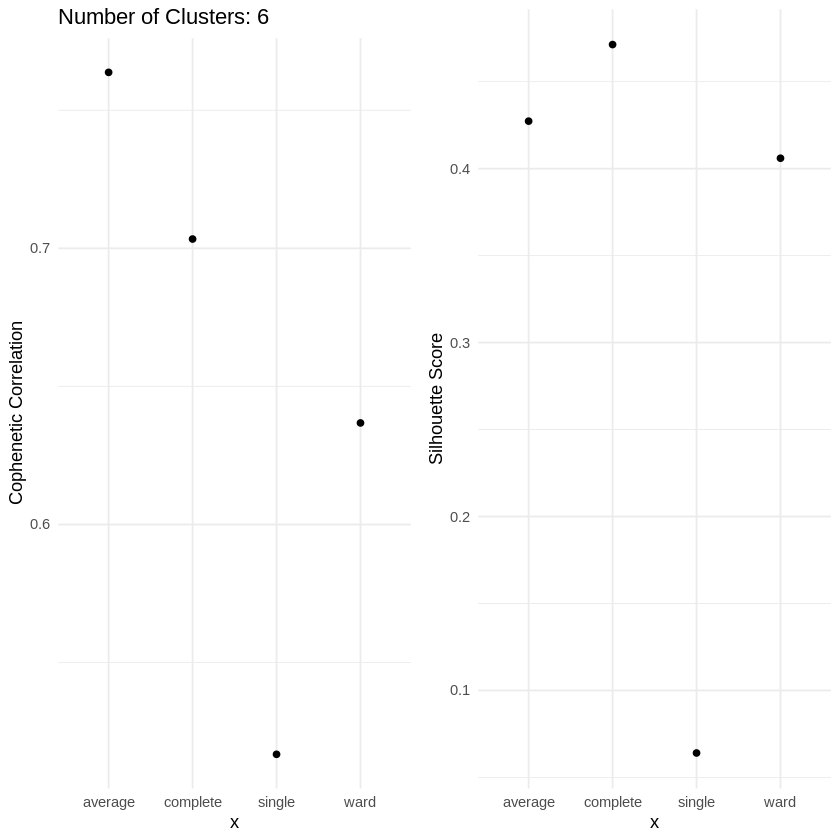

In [6]:
i=2
p1 <- ggplot(data.frame(x = linkages, y = cpcs[, i]), aes(x, y)) +
  geom_line() +
  geom_point() +
  labs(title = paste("Number of Clusters:", nb_clusters[i]), y = "Cophenetic Correlation") +
  theme_minimal()
p2 <- ggplot(data.frame(x = linkages, y = silhouette_scores[, i]), aes(x, y)) +
  geom_line() +
  geom_point() +
  labs(y = "Silhouette Score") +
  theme_minimal()
plot_list[[i]] <- grid.arrange(p1, p2, nrow = 1)

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


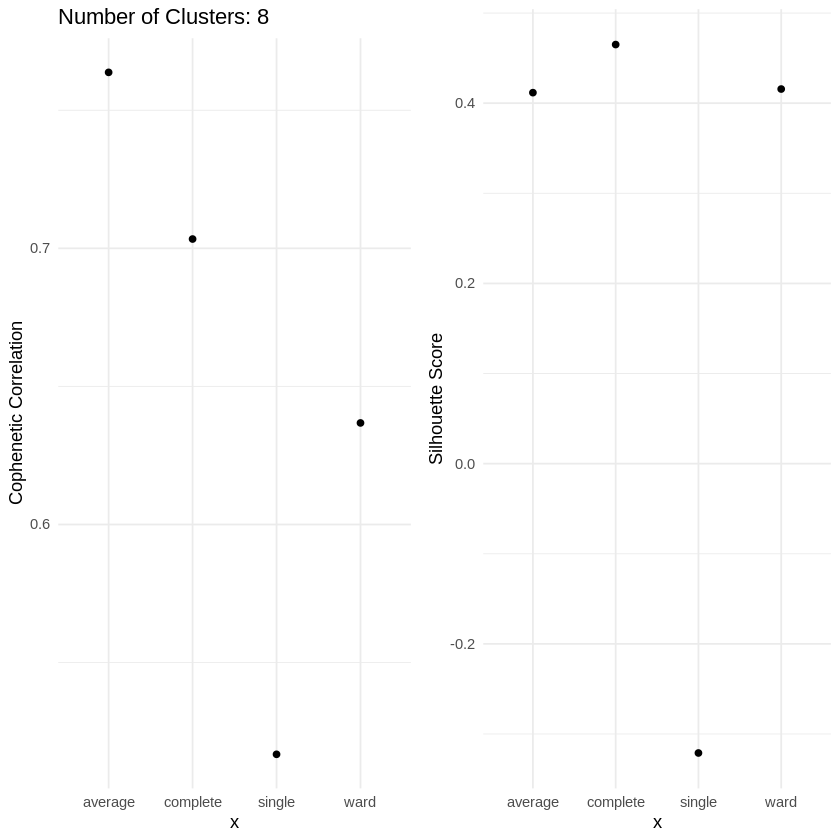

In [7]:
i=3
p1 <- ggplot(data.frame(x = linkages, y = cpcs[, i]), aes(x, y)) +
  geom_line() +
  geom_point() +
  labs(title = paste("Number of Clusters:", nb_clusters[i]), y = "Cophenetic Correlation") +
  theme_minimal()
p2 <- ggplot(data.frame(x = linkages, y = silhouette_scores[, i]), aes(x, y)) +
  geom_line() +
  geom_point() +
  labs(y = "Silhouette Score") +
  theme_minimal()
plot_list[[i]] <- grid.arrange(p1, p2, nrow = 1)

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


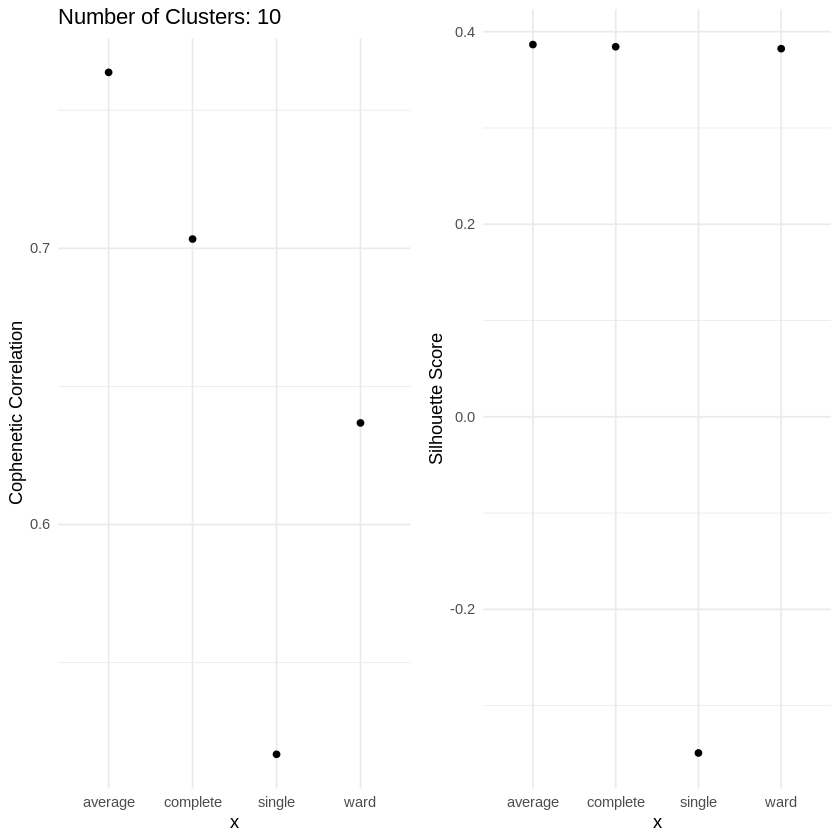

In [8]:
i=4
p1 <- ggplot(data.frame(x = linkages, y = cpcs[, i]), aes(x, y)) +
  geom_line() +
  geom_point() +
  labs(title = paste("Number of Clusters:", nb_clusters[i]), y = "Cophenetic Correlation") +
  theme_minimal()
p2 <- ggplot(data.frame(x = linkages, y = silhouette_scores[, i]), aes(x, y)) +
  geom_line() +
  geom_point() +
  labs(y = "Silhouette Score") +
  theme_minimal()
plot_list[[i]] <- grid.arrange(p1, p2, nrow = 1)

El primer elemento a considerar es que la correlación cofenética es razonablemente aceptable para el enlace completo (complete linkage) y el enlace promedio (average linkage), mientras que es demasiado baja para el enlace simple (single linkage). Considerando las puntuaciones de silueta, el valor máximo (alrededor de 0.6) se logra con el enlace simple y cuatro grupos. Este resultado indica que se pueden separar cuatro regiones con un nivel medio o alto de cohesión interna, incluso si el algoritmo jerárquico produce una configuración subóptima.

Como se explicó en la sección anterior, la correlación cofenética a veces puede ser engañosa y, en este caso, podemos concluir que, si el número teórico de grupos potenciales es cuatro, usar el enlace simple es la mejor opción. Sin embargo, todos los demás diagramas muestran un máximo correspondiente al enlace completo (y un mínimo para el enlace simple). Por lo tanto, la primera pregunta a responder es: ¿necesitamos incluso grupos? En este ejemplo, asumamos que muchas plantas operan de manera muy estándar (con diferencias compartidas por muchas muestras), pero también puede haber algunos casos particulares (valores atípicos impropios) que pueden exhibir un comportamiento muy diferente.

Dicha hipótesis es realista en muchos contextos y puede ser debido a procesos innovadores o experimentales, falta de recursos, problemas internos durante las mediciones, etc. Un experto en el dominio puede confirmar o rechazar nuestra suposición, pero, como este es un ejemplo genérico, podemos decidir conservar ocho grupos con enlace completo (con una puntuación de silueta de alrededor de 0.5). Este valor indica la presencia de solapamientos, pero, considerando la dimensionalidad del conjunto de datos y la no convexidad, puede ser aceptable en muchos casos de la vida real.

En este punto, también podemos analizar el dendrograma truncado a 80 hojas (esto es posible configurando el parámetro  `truncate_mode='lastp'` y `p=80`), para evitar intervalos demasiado pequeños y difíciles de distinguir (sin embargo, puedes eliminar esta restricción y aumentar la resolución):


NameError: name 'pdist' is not defined

Como se puede observar, el proceso de aglomeración no es homogéneo. Al principio del proceso, la disimilitud aumenta bastante lentamente, pero después de un valor aproximado de 10,000, los saltos se vuelven más grandes. Observando el gráfico t-SNE, es posible entender que el efecto de las no-convexidades tiene un impacto más fuerte en grupos muy grandes debido a que la densidad disminuye e implícitamente la disimilitud crece. Es evidente que un número muy pequeño de grupos (por ejemplo, 1, 2 o 3) se caracteriza por disimilitudes internas muy altas y una cohesión bastante baja.

Además, el dendrograma muestra que hay dos principales agregaciones desiguales en un nivel de aproximadamente 17,000, por lo que podemos deducir que el análisis de gran tamaño destaca la presencia de un comportamiento dominante (observando el gráfico desde arriba) y uno secundario, utilizado por un número menor de plantas. En particular, el grupo más pequeño es muy estable, ya que se fusionará en un único grupo final a un nivel de disimilitud de aproximadamente 50,000. Por lo tanto, deberíamos esperar la presencia de pseudo-valores atípicos agrupados en regiones más aisladas (esto también es confirmado por el gráfico t-SNE).

Al cortar a un nivel en el rango de 4,000 a 6,000 (correspondiente a aproximadamente ocho grupos), el bloque más grande es más denso que los más pequeños. En otras palabras, los grupos atípicos contendrán muchas menos muestras que los otros grupos. Esto no es sorprendente porque, como se discutió anteriormente, los grupos más distantes normalmente se fusionan bastante tarde en el enlace completo.

En este punto, finalmente podemos realizar el agrupamiento y verificar el resultado. La implementación de ``Scikit-learn`` no calcula todo el dendrograma, sino que detiene el proceso cuando se ha alcanzado el número deseado de grupos (a menos que el parámetro `compute_full_tree` no sea ``True``):


Como se esperaba, los grupos son desiguales, pero son bastante coherentes con la geometría. Además, los grupos aislados (por ejemplo, en la región $x ∈ (-40, -20)$ e $y > 60)$ son muy pequeños y es muy probable que contengan valores atípicos reales, cuyo comportamiento es muy diferente a la mayoría de las otras muestras. No vamos a analizar la semántica, porque el problema es muy específico. Sin embargo, **es razonable pensar que el grupo grande en la región $x ∈ (-40, 40)$ e $y ∈ (-40, -10)$, aunque no sea convexo, representa una línea base adecuada**. Por otro lado, **los otros bloques grandes (en los extremos de este grupo) corresponden a plantas con propiedades o comportamientos específicos, los cuales están suficientemente difundidos como para considerarse prácticas alternativas estándar**. Por supuesto, como se mencionó al principio, este es un análisis agnóstico, que debería ser útil para comprender cómo trabajar con el agrupamiento jerárquico.

Como paso final, queremos cortar el dendrograma a un nivel de disimilitud de aproximadamente 35,000 (correspondiente a dos grupos). El resultado se muestra en la siguiente captura de pantalla.

A este nivel, el dendrograma muestra un gran porcentaje de muestras pertenecientes a un grupo y un bloque más pequeño restante. Ahora sabemos que esa región secundaria corresponde a $x ∈ (-40, 10)$ e $y > 20$. Nuevamente, el resultado no es sorprendente, porque el gráfico t-SNE muestra que estas muestras son las únicas con $y > 20 ÷ 25$ (mientras que el grupo más grande, incluso con una vasta región vacía, cubre casi todo el rango).

Por lo tanto, podríamos afirmar que tales muestras representan plantas muy diferentes con comportamientos extremos y, si una nueva muestra se asigna a ese grupo, probablemente sea una planta no estándar (asumiendo que una planta estándar tiene un comportamiento similar a la mayoría de sus pares). Como ejercicio, te animo a probar otras cantidades de grupos y diferentes enlaces (en particular, el enlace simple, que es muy peculiar), y tratar de validar o rechazar algunas hipótesis previas (no es necesario que sean aceptables físicamente).

## Restricciones de Conectividad

Una característica importante de la agrupación jerárquica aglomerativa es la posibilidad de incluir restricciones de conectividad para forzar la fusión de muestras específicas. Este tipo de conocimiento previo es muy común en contextos donde existen relaciones fuertes entre vecinos o cuando sabemos que algunas muestras deben pertenecer al mismo grupo debido a sus propiedades intrínsecas. Para lograr este objetivo, es necesario utilizar una matriz de conectividad, $A ∈ {0, 1}^{n × n}$:

$A_{ij}= \left\{
\begin{array}{ll}
      [1] \:\:\:\text{if} \: \bar{x}_i \: \text{and} \: \bar{x}_i \: \text{are conected}\\
      [0] \:\:\:\text{otherwise}\\
\end{array}
\right.
$

En general, $A$ es la matriz de adyacencia inducida por un grafo del conjunto de datos; sin embargo, el único requisito importante es la ausencia de muestras aisladas (sin conexiones), ya que no se pueden fusionar de ninguna manera. La matriz de conectividad se aplica durante las etapas iniciales de fusión y obliga al algoritmo a agregar las muestras especificadas. Dado que las fusiones siguientes no afectan la conectividad (dos muestras o grupos fusionados permanecerán fusionados hasta el final del proceso), las restricciones siempre se aplican.

Para comprender este proceso, consideremos un conjunto de datos de muestra que contiene 50 puntos bidimensionales extraídos de 8 distribuciones gaussianas bivariadas:


Al observar el gráfico, notamos que las muestras 18 y 31 ($x_0 ∈ (-2, -1)$ y $x_1 ∈ (1, 2)$) están bastante cerca; sin embargo, no queremos que se fusionen porque la muestra 18 tiene muchos más vecinos en el gran grupo central, mientras que el punto 31 está parcialmente aislado y debería considerarse un clúster autónomo. También queremos que la muestra 33 forme un único clúster. Estos requisitos obligarán al algoritmo a fusionar clústeres sin respetar más la geometría subyacente (en términos de distribuciones gaussianas), sino más bien el conocimiento previo.
Para verificar cómo funciona el agrupamiento, calculemos ahora el dendrograma (truncado a 20 hojas) utilizando la distancia euclidiana y enlace promedio:

Como se esperaba, las muestras 18 y 31 se fusionan inmediatamente y luego se agregan a otro clúster que contiene 2 muestras (cuando el número está entre paréntesis, significa que es un bloque compuesto que contiene más muestras), que probablemente sean 44 y 13. La muestra 33 también se fusiona, por lo que no permanecerá en un clúster aislado. Como confirmación, realicemos el agrupamiento con n_clusters=8:

El resultado confirma el análisis previo. Sin restricciones, el enlace promedio produce una partición razonable que es compatible con la verdad fundamental (ocho distribuciones gaussianas). Para dividir el gran grupo central y mantener el número requerido de clústeres, el algoritmo está obligado a fusionar también las muestras aisladas, incluso si el dendrograma confirma que se fusionan al final, en los niveles más altos de disimilitud.

Para imponer nuestras restricciones, podemos observar que una matriz de conectividad basada en los dos primeros vecinos más cercanos es muy probable que fuerce la agregación de todas las muestras pertenecientes a las regiones más densas (considerando que los vecinos están más cerca) y termine manteniendo los puntos aislados en clústeres autónomos. El motivo de este comportamiento hipotético se basa en el objetivo del enlace promedio (minimizar la distancia promedio entre clústeres). Por lo tanto, después de imponer las restricciones, el algoritmo tiende más a agregar clústeres cercanos con otros vecinos (recuerda que A tiene valores nulos, pero en las posiciones correspondientes a los dos vecinos más cercanos) y a dejar sin fusionar los puntos más alejados hasta que el nivel de disimilitud sea lo suficientemente grande (produciendo clústeres muy desiguales).

Para comprobar si nuestra suposición es cierta, generemos una matriz de conectividad utilizando la función ``kneighbors_graph()`` de ``scikit-learn``, con ``n_neighbors=2``, y volvamos a agrupar el conjunto de datos, estableciendo la restricción de conectividad.

Como se esperaba, la muestra 18 ha sido asignada al gran clúster central, mientras que los puntos 31 y 33 están ahora aislados. Por supuesto, dado que el proceso es jerárquico, es más fácil imponer las restricciones de conectividad que las de separación. De hecho, si bien las muestras individuales pueden fusionarse fácilmente durante las etapas iniciales, su exclusión antes de la fusión final no puede garantizarse fácilmente utilizando todos los enlaces.

Cuando se requieren restricciones complejas (dada una distancia y un enlace), a menudo es necesario ajustar tanto la matriz de conectividad como el número deseado de clústeres. Por supuesto, si el resultado deseado se logra con un número específico de clústeres, también se logrará con valores más grandes hasta un límite inferior de disimilitud (es decir, el proceso de fusión reduce el número de clústeres; por lo tanto, si la disimilitud es lo suficientemente grande, todas las restricciones existentes permanecerán válidas). Por ejemplo, si se restringe que tres muestras pertenezcan al mismo clúster, generalmente no podemos esperar este resultado después de las etapas iniciales de fusión.

Sin embargo, si la fusión de las tres muestras ocurre a cierto nivel de disimilitud ($DL$ en inglés por *dissimilarity level*) (por ejemplo, $DL=2.0$ correspondiente a 30 clústeres), también será válido para $n < 30$ clústeres y para todas las configuraciones con $DL > 2.0$. Por lo tanto, si comenzamos con 5 clústeres, podemos aumentar fácilmente este número asegurándonos de tener un nivel de disimilitud que sea mayor que el correspondiente a la última fusión impuesta por las restricciones. Te animo a probar este método con otros conjuntos de datos e intentar definir restricciones previas que puedan verificarse fácilmente después del proceso de agrupamiento.